In [1]:
import pandas as pd    
import geopandas as gpd
import datetime
from geopandas.tools import geocode
#import geoplot
from shapely.geometry import Point
import numpy as np
import scipy.stats as stats
import scipy
import shapely
from shapely import speedups
speedups.enabled
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

# `zips`: zip code boundaries

In [2]:
# Loads zip code boundary data
zipcodes_url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
z = gpd.read_file(zipcodes_url)

In [3]:
# Creates a dataframe "zips" of zip codes, areas, and geometries
zip_cols = ['ZIPCODE', 'SHAPE_Area', 'geometry']
zips = z.loc[:,zip_cols]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)

new_cols = ['Zipcode', 'Area (ft^2)?']
rename_dict = {}
for i in range(len(zip_cols)-1):
    rename_dict[zip_cols[i]] = new_cols[i]
zips.rename(columns=rename_dict, inplace=True)
zips.sort_values(by='Zipcode', inplace=True)
zips.set_index(np.arange(0,len(zips),1), inplace=True)
zips.index.name = 'ID'

In [4]:
zips.head()

,Zipcode,Area (ft^2)?,geometry
ID,,,
0,98001,5.324255e+08,"POLYGON ((-122.22992 47.35377, -122.22992 47.3..."
1,98002,2.055688e+08,"POLYGON ((-122.22921 47.35375, -122.22921 47.3..."
2,98003,3.170769e+08,"POLYGON ((-122.30960 47.35795, -122.31323 47.3..."
3,98004,2.014501e+08,"MULTIPOLYGON (((-122.21458 47.65298, -122.2147..."
4,98005,2.113641e+08,"POLYGON ((-122.15876 47.66065, -122.16408 47.6..."


# `tracts`: census tract boundaries

In [5]:
# Loads census tract boundary data
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
t = gpd.read_file(census_url)

In [6]:
# Creates a dataframe "tracts" of tract number, areas, and geometries
tract_cols = ['NAME10', 'SHAPE_Area', 'geometry']
tracts = t.loc[:,tract_cols]
tracts['NAME10'] = tracts['NAME10'].astype(float)
new_cols = ['Tract', 'Area (ft^2)?', 'geometry']
rename_dict = {}
for i in range(len(tract_cols)):
    rename_dict[tract_cols[i]] = new_cols[i]
tracts.rename(columns=rename_dict, inplace=True)
tracts.sort_values(by='Tract', inplace=True)
tracts.set_index(np.arange(0,len(tracts),1), inplace=True)
tracts.index.name = 'ID'

In [7]:
# Filters out tracts with irregular traffic data
filter1 = tracts.Tract == 260.01
filter2 = tracts.Tract == 264.0
indices1 = tracts[filter1].index
indices2 = tracts[filter2].index
tracts.drop(indices1, inplace=True)
tracts.drop(indices2, inplace=True)

In [8]:
tracts.head()

,Tract,Area (ft^2)?,geometry
ID,,,
0,1.00,1.990374e+07,"POLYGON ((-122.29605 47.73378, -122.29651 47.7..."
1,2.00,3.537107e+07,"POLYGON ((-122.29634 47.72109, -122.29636 47.7..."
2,3.00,1.302888e+07,"POLYGON ((-122.32555 47.73407, -122.32561 47.7..."
3,4.01,1.467846e+07,"POLYGON ((-122.34501 47.72633, -122.34502 47.7..."
4,4.02,1.936217e+07,"POLYGON ((-122.34498 47.72324, -122.34633 47.7..."


# `ziptracts`: zip codes joined with census tracts

In [9]:
# Joins zip codes with census tracts
ziptracts = gpd.sjoin(zips, tracts, op='overlaps')
zip_cols = ['Zipcode', 'Tract', 'Area (ft^2)?_left', 'geometry']
ziptracts = ziptracts[zip_cols]
ziptracts.rename(columns={'Area (ft^2)?_left': 'Area (ft^2)?'}, inplace=True)

In [10]:
# Defines x and y boundaries of area covered by tracts
minx = min(tracts.geometry.bounds.minx)
maxx = max(tracts.geometry.bounds.maxx)
miny = min(tracts.geometry.bounds.miny)
maxy = max(tracts.geometry.bounds.maxy)

# Shrinks the area covered by ziptracts to the area covered by tracts
minx_filter = minx < ziptracts.geometry.bounds.minx
maxx_filter = maxx > ziptracts.geometry.bounds.maxx
miny_filter = miny < ziptracts.geometry.bounds.miny
maxy_filter = maxy > ziptracts.geometry.bounds.maxy

ziptracts = ziptracts[minx_filter & maxx_filter & miny_filter & maxy_filter]

<AxesSubplot:>

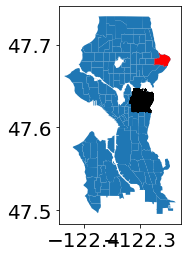

In [11]:
# Plot zipcodes, tracts, and bike racks
zt = ziptracts[ziptracts.Zipcode==98112]
tr = tracts[tracts.Tract==40]

fig, ax = plt.subplots()
tracts.plot(ax=ax)
#tracts.plot(ax=ax)#, color='blue')
zt.plot(ax=ax, color='black')
tr.plot(ax=ax, color='red')
#racks.iloc[:30].plot(ax=ax, color='black')

In [19]:
# List of areas (zip codes)
'''
zip_list = np.sort(list(set(zips['ZIPCODE'])))

# Creates 3 lists that contain for each zip code: 1) a list of included tracts, 2) area, and 3) geometry
tracts = []*len(zip_list)
areas = []
geometries = []

for zipcode in zip_list:
    filter = zips['ZIPCODE'] == zipcode
    area_tracts = [tract for tract in zips[filter]['NAME10']]
    tracts.append(area_tracts)
    
    index = zips[zips['ZIPCODE']==zipcode].index[0]
    area = zips.iloc[index]['SHAPE_Area_left']
    geometry = zips.iloc[index]['geometry']
    areas.append(area)
    geometries.append(geometry)
    
# Creates dataframe of zip codes, included tracts, area, and geometry
zips_cleaned = gpd.GeoDataFrame()
zips_cleaned['Zipcode'] = zip_list
zips_cleaned['Tracts'] = tracts
zips_cleaned['Area'] = areas
zips_cleaned['geometry'] = geometries
'''

"\nzip_list = np.sort(list(set(zips['ZIPCODE'])))\n\n# Creates 3 lists that contain for each zip code: 1) a list of included tracts, 2) area, and 3) geometry\ntracts = []*len(zip_list)\nareas = []\ngeometries = []\n\nfor zipcode in zip_list:\n    filter = zips['ZIPCODE'] == zipcode\n    area_tracts = [tract for tract in zips[filter]['NAME10']]\n    tracts.append(area_tracts)\n    \n    index = zips[zips['ZIPCODE']==zipcode].index[0]\n    area = zips.iloc[index]['SHAPE_Area_left']\n    geometry = zips.iloc[index]['geometry']\n    areas.append(area)\n    geometries.append(geometry)\n    \n# Creates dataframe of zip codes, included tracts, area, and geometry\nzips_cleaned = gpd.GeoDataFrame()\nzips_cleaned['Zipcode'] = zip_list\nzips_cleaned['Tracts'] = tracts\nzips_cleaned['Area'] = areas\nzips_cleaned['geometry'] = geometries\n"

### Assignment of tracts to zip codes is off; may need to hardcode zip codes

In [25]:
# Plots zip codes containing a given tract number
'''
tract = 97.01
rows = []

for i in range(len(ziptracts.Tracts)):
    if tract in ziptracts.Tracts[i]:
        rows.append(i)
query = ziptracts.iloc[rows,:]

fig, ax = plt.subplots()
ziptracts.plot(ax=ax, edgecolor='white')
query.plot(ax=ax, color='red')
'''

"\ntract = 97.01\nrows = []\n\nfor i in range(len(ziptracts.Tracts)):\n    if tract in ziptracts.Tracts[i]:\n        rows.append(i)\nquery = ziptracts.iloc[rows,:]\n\nfig, ax = plt.subplots()\nziptracts.plot(ax=ax, edgecolor='white')\nquery.plot(ax=ax, color='red')\n"

# `racks`:  bike racks

In [12]:
# Loads bike rack data
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
r = gpd.read_file(racks_url)

In [13]:
# Creates a dataframe "racks" of bike rack locations and years installed
racks = r[['INSTALL_DATE', 'geometry']]
racks = racks[racks.INSTALL_DATE.notnull()]
racks['Year'] = pd.DatetimeIndex(racks['INSTALL_DATE']).year
racks = racks.drop(columns='INSTALL_DATE')

In [14]:
# Shrinks the area covered by bike racks to the area covered by tracts
minx_filter = minx < racks.geometry.bounds.minx
maxx_filter = maxx > racks.geometry.bounds.maxx
miny_filter = miny < racks.geometry.bounds.miny
maxy_filter = maxy > racks.geometry.bounds.maxy

racks = racks[minx_filter & maxx_filter & miny_filter & maxy_filter]

# `zipracks`:  zip codes joined with bike racks

In [16]:
# # Joins zip codes with bike racks
zr = gpd.sjoin(ziptracts, racks, op='contains')

In [17]:
zr.head()

,Zipcode,Tract,Area (ft^2)?,geometry,index_right,Year
ID,,,,,,
58,98101,81.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",3648,2018
58,98101,82.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",3648,2018
58,98101,83.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",3648,2018
58,98101,80.02,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",3648,2018
58,98101,84.00,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",3648,2018


In [18]:
# Creates a dataframe "zipracks" of zip codes, years, and area density of bike racks (*10^6)
zipracks = zr.groupby(['Zipcode', 'Year']).size().reset_index()
zipracks.rename(columns={0: 'Num_racks'}, inplace=True)
zip_list = zipracks.Zipcode.unique()
for zip in zip_list:
    indices = zipracks[zipracks.Zipcode==zip].index
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'].cumsum()
    area = ziptracts[ziptracts.Zipcode==zip]['Area (ft^2)?'].unique()
    zipracks.loc[indices, 'Num_racks'] = zipracks.loc[indices, 'Num_racks'] / area * 10**6
zipracks.rename(columns={'Num_racks': 'Density_racks'}, inplace=True)

The column `zipracks['Density_racks']` has units of $10^{-6}$ racks/$ft^2$.

In [19]:
zipracks.head()

,Zipcode,Year,Density_racks
0,98101,2000,0.612240
1,98101,2001,1.224480
2,98101,2002,7.346877
3,98101,2003,7.959117
4,98101,2004,9.183597


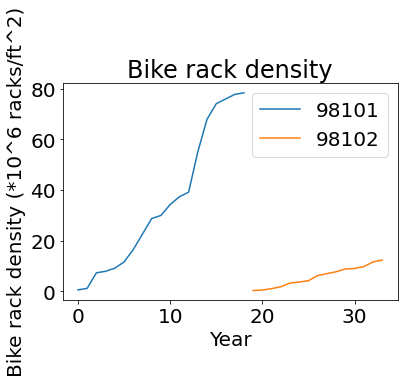

In [20]:
# Plots bike racks for two zip codes over time
fig, ax = plt.subplots()
zip1 = 98101
zip2 = 98102
zipracks[zipracks.Zipcode==zip1].Density_racks.plot(ax=ax, label=f'{zip1}')
zipracks[zipracks.Zipcode==zip2].Density_racks.plot(ax=ax, label=f'{zip2}')
ax.set_title('Bike rack density')
ax.set_xlabel('Year')
ax.set_ylabel('Bike rack density (*10^6 racks/ft^2)')
ax.legend()

### I have not touched the code below...

## Parking data

In [207]:
#Parking -- street signs indicate parking zone and date of installation
street_signs_url = 'https://gisdata.seattle.gov/server/rest/services/SDOT/SDOT_Signs/MapServer/0/query?where=1%3D1&outFields=OBJECTID,COMPKEY,COMPTYPE,CATEGORY,CATEGORYDESCR,ADDDTTM,MODDTTM,INSTDATE,SHAPE_LNG,SHAPE_LAT&outSR=4326&f=json'
street_signs = gpd.read_file(street_signs_url)

In [208]:
street_signs.head()

,OBJECTID,COMPKEY,COMPTYPE,CATEGORY,CATEGORYDESCR,ADDDTTM,MODDTTM,INSTDATE,SHAPE_LNG,SHAPE_LAT,geometry
0,1,98273,20,PNP,"No Parking, but ""standing"" allowed ...",1026777600000,1261526400000,None,-122.347251,47.632256,POINT (-122.34725 47.63226)
1,2,146758,20,PNP,"No Parking, but ""standing"" allowed ...",1026777600000,1261526400000,None,-122.382014,47.672413,POINT (-122.38201 47.67241)
2,3,661338,20,PLU,"15 or 30 minute load zones, may be paid ...",1472688000000,1472688000000,1472083200000,-122.326271,47.581133,POINT (-122.32627 47.58113)
3,4,691712,20,WARNCW,Warning-Crosswalk ...,1509321600000,1509321600000,1503964800000,-122.313534,47.557108,POINT (-122.31353 47.55711)
4,5,148740,20,PNS,"No stopping, standing or parking ...",1026777600000,1261526400000,None,-122.378979,47.666722,POINT (-122.37898 47.66672)


## Bike lane and walkway data

In [5]:
#Bike lanes and walkways
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

## Population data

In [6]:
#Population
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'
#pop_url_2000

## Traffic ##

In [7]:
url_list = ['https://opendata.arcgis.com/datasets/7015d5d46a284f94ac05c2ea4358bcd7_0.geojson',
            'https://opendata.arcgis.com/datasets/5fc63b2a48474100b560a7d98b5097d7_1.geojson',
            'https://opendata.arcgis.com/datasets/27af9a2485c5442bb061fa7e881d7022_2.geojson',
            'https://opendata.arcgis.com/datasets/4f62515558174f53979b3be0335004d3_3.geojson',
            'https://opendata.arcgis.com/datasets/29f801d03c9b4b608bca6a8e497278c3_4.geojson',
            'https://opendata.arcgis.com/datasets/a0019dd0d6464747a88921f5e103d509_5.geojson',
            'https://opendata.arcgis.com/datasets/40bcfbc4054549ebba8b5777bbdd40ff_6.geojson',
            'https://opendata.arcgis.com/datasets/16cedd233d914118a275c6510115d466_7.geojson',
            'https://opendata.arcgis.com/datasets/902fd604ecf54adf8579894508cacc68_8.geojson',
            'https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson',
            'https://opendata.arcgis.com/datasets/2c37babc94d64bbb938a9b520bc5538c_10.geojson',
            'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.geojson']

In [72]:
def get_gdf(year):
    '''Enter the desired year to download the traffic flow count
    data for that year. Example: enter '7' for the year 2007.
    '''
    num = year-7
    gdf_year = gpd.read_file(url_list[num])
    if year == 11:
        gdf_year = gdf_year.rename(columns={"YEAR_" : 'YEAR'})
    if year == 12:
        gdf_year = gdf_year.rename(columns={'STDY_YEAR' : 'YEAR'})
    if year == 15 or year == 16:
        gdf_year = gdf_year.rename(columns={"COUNTAAWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'FIRST_STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 15:
            year_list = ['2015']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 16:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    elif year == 17 or year == 18:
        gdf_year = gdf_year.rename(columns={"AWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 17:
            year_list = ['2017']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 18:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    #df_year_AAWDT = df_year['AAWDT'].values
    #df_year_geobase = df_year['GEOBASID'].values
    #df_year_dist = df_year['SHAPE_Length'].values
    gdf_year = gdf_year[[ 'YEAR', 'AAWDT','geometry']]
    return gdf_year #, df_year_AAWDT, df_year_geobase, df_year_dist

In [114]:
def get_traffic_df(year):
    gdf_year = get_gdf(year)
    traffic = gpd.sjoin(gdf_year,census_bounds_cleaned,op='intersects')
    traffic['TOTAL FLOW DENSITY'] = 43650*traffic['AAWDT'] / traffic['SHAPE_Area']
    #traffic_clean = traffic.drop(columns=['index_right','SHAPE_Area'])
    #traffic_clean.dissolve(by='NAME10')
    df_traffic = traffic.dissolve(by='NAME10')
    df = df_traffic.drop(columns=['geometry','AAWDT','index_right','SHAPE_Area'])

    return df

## Bike Lanes ##

In [11]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike = df_SND[lane_columns]

In [12]:
# Creates list of years in each row
snd_years = []
for i in df_SND['SNDSEG_UPD'].values:
    snd_years.append(int(i[0:4]))
    
snd_year = snd_years
snd_year_df = pd.Series(snd_year)

In [53]:
bike['YEAR'] = snd_year_df

In [54]:
#Specify segment type to extract, for walkways this will be 5
bike = bike[bike['SEGMENT_TY']==6]


In [15]:
bike_cleaned = bike.drop(columns=['SNDSEG_UPD', 'SEGMENT_TY'])

In [55]:
lane_by_tract = gpd.sjoin(census_bounds_cleaned, bike, op='intersects')
lanes_years = lane_by_tract.dissolve(by=['NAME10','YEAR'])
lanes_years.drop(columns=['geometry','SHAPE_Area','index_right'])

SEGMENT_TY  SNDSEG_UPD  SHAPE_Leng
NAME10 YEAR                                    
1      2011           6  2011-02-24  398.194434
10     2013           6  2013-02-01  132.485680
       2017           6  2017-02-03  209.540786
100.01 2017           6  2017-03-15  226.928120
100.02 2004           6  2004-05-19  138.151384
...                 ...         ...         ...
99     2011           6  2011-02-24  216.416233
       2014           6  2014-12-18   65.067733
       2015           6  2015-05-22   59.955099
       2017           6  2017-02-02  148.163251
       2018           6  2018-03-23  103.611745

[173 rows x 3 columns]

In [56]:
#Automate this process into function
#Take multiindexed DF as shown above, convert and process to form below
lengths = pd.Series(43560*lanes_years['SHAPE_Leng'].values / lanes_years['SHAPE_Area'].values)

year_lane = []
tract_lane = []

for i in range(np.size(lengths)):
    year_lane.append(lanes_years.index.values[i][0])
for k in range(np.size(lengths)):
    tract_lane.append(lanes_years.index.values[k][1])

df_lanes = pd.DataFrame(np.stack((year_lane,tract_lane,lengths)).T)

In [57]:
df_lanes.head()

,0,1,2
0,1,2011,0.8714617619474354
1,10,2013,0.561771181757596
2,10,2017,0.8885033805558079
3,100.01,2017,0.3968428770965108
4,100.02,2004,0.5896069313812291


In [19]:
import os

In [20]:
print(os.path)

<module 'posixpath' from '/Users/stlp/opt/anaconda3/lib/python3.8/posixpath.py'>


In [21]:
#df_lanes.to_csv(r'~/Project/Prediction/df_lanes.csv')

In [22]:
#pd.read_csv('df_lanes.csv')

## Walkways ##

In [23]:
walk_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
walk = df_SND[walk_columns]
walk.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry
0,1,2007-04-22,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."
1,1,2007-04-22,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47..."
2,1,2004-05-19,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47..."
3,6,2004-05-19,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47..."
4,1,2012-10-12,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47..."


In [24]:
walks_years = []
for k in walk['SNDSEG_UPD'].values:
    walks_years.append(int(k[0:4]))

walk_years = walks_years

In [25]:
walk['YEAR'] = pd.Series(walk_years)

/Users/stlp/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [26]:
walks = walk[walk['SEGMENT_TY']==5]

In [27]:
walks_cleaned = walks.drop(columns=['SEGMENT_TY'])

In [28]:
walks_data = walks_cleaned.dissolve('YEAR')
walks_data.head(n=25)

,geometry,SNDSEG_UPD,SHAPE_Leng
YEAR,,,
2004,"MULTILINESTRING ((-122.31491 47.69172, -122.31...",2004-07-19,165.967550
2005,"LINESTRING (-122.32653 47.64449, -122.32653 47...",2005-05-04,412.348264
2008,"LINESTRING (-122.38645 47.54191, -122.38646 47...",2008-04-09,465.983637
2014,"LINESTRING (-122.38163 47.69059, -122.38162 47...",2014-12-18,665.738612
2015,"MULTILINESTRING ((-122.34646 47.53375, -122.34...",2015-03-27,666.636653
2016,"MULTILINESTRING ((-122.39294 47.65711, -122.39...",2016-12-23,471.639054
2017,"MULTILINESTRING ((-122.30118 47.64349, -122.30...",2017-03-14,247.401227
2018,"MULTILINESTRING ((-122.39685 47.56481, -122.39...",2018-08-07,205.825219
2019,"MULTILINESTRING ((-122.32441 47.59919, -122.32...",2019-02-08,306.056518


In [58]:
walks_by_tract = gpd.sjoin(census_bounds_cleaned, walks_data, op='intersects')
walks_by_tract.dissolve(by=['index_right','NAME10'])
walks_by_tract.drop(columns=['geometry','SHAPE_Area','SNDSEG_UPD'])

,NAME10,index_right,SHAPE_Leng
8,58.01,2016,471.639054
123,80.01,2016,471.639054
126,71,2016,471.639054
11,32,2018,205.825219
47,43.01,2018,205.825219
50,44,2018,205.825219
60,92,2018,205.825219
116,107.02,2018,205.825219
118,99,2018,205.825219
119,97.02,2018,205.825219


## Bike Racks ##

In [30]:
racks_df = gpd.read_file('Bike_Racks.geojson')
racks_df.head()

,OBJECTID,COMPKEY,COMPTYPE,SEGKEY,DISTANCE,WIDTH,UNITID,UNITTYPE,UNITDESC,BIKE_FACILITY,...,SIDE,OWNERSHIP,CURRENT_STATUS,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,OVERRIDEYN,OVERRIDECOMMENT,SHAPE_LNG,SHAPE_LAT,geometry
0,1,519234,16,12044,240.0,30.0,BKR-2855,BKR,OLIVE WAY 0060 BLOCK NW SIDE ( 225) 51 FT SW/O...,SGL,...,NW,SDOT,INSVC,DISTRICT7,,N,None,-122.335519,47.613547,POINT (-122.33552 47.61355)
1,2,518964,16,17977,512.0,-28.0,BKR-1790,BKR,NE BOAT ST 0110 BLOCK SW SIDE ( 512) 363 FT NW...,SGL,...,SW,SDOT,INSVC,DISTRICT4,,N,None,-122.316016,47.652276,POINT (-122.31602 47.65228)
2,3,519236,16,12045,216.0,29.0,BKR-2895,BKR,OLIVE WAY 0070 BLOCK NW SIDE ( 196) 80 FT SW/O...,SGL,...,NW,SDOT,INSVC,DISTRICT7,,N,None,-122.334488,47.613973,POINT (-122.33449 47.61397)
3,4,519257,16,9538,310.0,-25.0,BKR-1107,BKR,CALIFORNIA AVE SW 0220 BLOCK W SIDE ( 280) 27 ...,SGL,...,W,SDOT,INSVC,DISTRICT1,,N,None,-122.386571,47.583156,POINT (-122.38657 47.58316)
4,5,640211,16,9479,509.0,-26.5,BKR-3674,BKR,BROOKLYN AVE NE 0410 BLOCK E SIDE ( 501) 10 FT...,ONST,...,E,SDOT,INSVC,DISTRICT4,,N,None,-122.314258,47.658240,POINT (-122.31426 47.65824)


## Parking ##

In [31]:
park_times = []
for timestamp in street_signs['ADDDTTM'].values:
    x = timestamp[:10]
    x_time = datetime.datetime.fromtimestamp(int(x)).isoformat()
    x_year = (int(x_time[0:4]))
    park_times.append(x_year)

In [32]:
street_signs['PARK YEAR'] = pd.Series(park_times)

In [33]:
keep_list = ['PPP','PR','PRZ','PTIML','PINST','PCARPL']

## Population ##

In [55]:
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'
#pop_url_2000 =

In [56]:
pop_2010 = gpd.read_file(pop_url_2010)

In [72]:
pop_2010['NAME10'] = pop_2010['NAME10'].astype(float)

In [73]:
pop_2010.head()

,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID,geometry
0,53033002500,25.0,243.219083,2802.0,1,"POLYGON ((-122.29602 47.69023, -122.29604 47.6..."
1,53033002600,26.0,307.584420,4660.0,2,"POLYGON ((-122.30817 47.69031, -122.30793 47.6..."
2,53033005600,56.0,737.511727,6382.0,3,"POLYGON ((-122.39300 47.63956, -122.39300 47.6..."
3,53033006800,68.0,177.438771,2834.0,4,"POLYGON ((-122.35070 47.63994, -122.35071 47.6..."
4,53033006000,60.0,324.567432,5150.0,5,"POLYGON ((-122.34279 47.64320, -122.34267 47.6..."


In [70]:
census_bounds.head(1)

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry
0,1,2500,002500,53033002500,25,Census Tract 25,243.219083,0,16442.968402,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."


In [71]:
census_bounds_cleaned.head(1)

,NAME10,SHAPE_Area,geometry
0,25.0,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."


In [85]:
pop_tracts = pd.merge(census_bounds_cleaned, pop_2010, on='NAME10')

In [86]:
pop_tracts.head()

,NAME10,SHAPE_Area,geometry_x,GEOID10,ACRES_TOTAL,Total_Population,OBJECTID,geometry_y
0,25.0,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6...",53033002500,243.219083,2802.0,1,"POLYGON ((-122.29602 47.69023, -122.29604 47.6..."
1,26.0,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6...",53033002600,307.584420,4660.0,2,"POLYGON ((-122.30817 47.69031, -122.30793 47.6..."
2,56.0,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6...",53033005600,737.511727,6382.0,3,"POLYGON ((-122.39300 47.63956, -122.39300 47.6..."
3,68.0,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6...",53033006800,177.438771,2834.0,4,"POLYGON ((-122.35070 47.63994, -122.35071 47.6..."
4,60.0,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6...",53033006000,324.567432,5150.0,5,"POLYGON ((-122.34279 47.64320, -122.34267 47.6..."


In [87]:
pop_tracts = pop_tracts[['NAME10', 'geometry_x', 'Total_Population']]

In [88]:
pop_tracts = pop_tracts.rename(columns={'geometry_x':'geometry'})

In [89]:
pop_tracts.head()

,NAME10,geometry,Total_Population
0,25.0,"POLYGON ((-122.29602 47.69023, -122.29608 47.6...",2802.0
1,26.0,"POLYGON ((-122.30817 47.69031, -122.30947 47.6...",4660.0
2,56.0,"POLYGON ((-122.39300 47.63956, -122.39421 47.6...",6382.0
3,68.0,"POLYGON ((-122.35070 47.63994, -122.35130 47.6...",2834.0
4,60.0,"POLYGON ((-122.34279 47.64320, -122.34280 47.6...",5150.0


In [78]:
total_pop = pop_tracts['Total_Population'].sum()
total_pop

608554.0

In [90]:
pop_tracts['Pop_fraction'] = pop_tracts['Total_Population']/total_pop
pop_tracts.head()

,NAME10,geometry,Total_Population,Pop_fraction
0,25.0,"POLYGON ((-122.29602 47.69023, -122.29608 47.6...",2802.0,0.004604
1,26.0,"POLYGON ((-122.30817 47.69031, -122.30947 47.6...",4660.0,0.007657
2,56.0,"POLYGON ((-122.39300 47.63956, -122.39421 47.6...",6382.0,0.010487
3,68.0,"POLYGON ((-122.35070 47.63994, -122.35130 47.6...",2834.0,0.004657
4,60.0,"POLYGON ((-122.34279 47.64320, -122.34280 47.6...",5150.0,0.008463


In [91]:
zips_cleaned.head()

,Zipcode,Tracts,Area,geometry
0,98101,"[81.0, 82.0, 83.0, 80.02, 84.0, 72.0, 74.02, 7...",8.818645e+07,"MULTIPOLYGON (((-122.30683 47.64729, -122.3123..."
1,98102,"[74.02, 73.0, 74.01, 75.0, 65.0, 66.0, 62.0, 6...",4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
2,98103,"[45.0, 46.0, 36.0, 27.0, 19.0, 12.0, 54.0, 49....",1.813559e+08,"POLYGON ((-122.27294 47.70107, -122.27337 47.7..."
3,98104,"[81.0, 82.0, 83.0, 84.0, 75.0, 93.0, 90.0, 91....",1.440083e+08,"POLYGON ((-122.32925 47.70319, -122.33052 47.7..."
4,98105,"[41.0, 42.0, 43.01, 45.0, 44.0, 46.0, 36.0, 54...",9.703543e+07,"MULTIPOLYGON (((-122.30978 47.67381, -122.3103..."


In [82]:
years = list(range(2007, 2019))
years

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [83]:
populations = [585436, 591870, 598539, 608660, 622694, 635928, 653588, 670109, 687386, 709631, 728661, 742235]

In [84]:
pop_by_year = dict(zip(years, populations))
pop_by_year

{2007: 585436,
 2008: 591870,
 2009: 598539,
 2010: 608660,
 2011: 622694,
 2012: 635928,
 2013: 653588,
 2014: 670109,
 2015: 687386,
 2016: 709631,
 2017: 728661,
 2018: 742235}

In [48]:
pop_by_year.get(2015)

687386

In [49]:
def est_tract_pop(year, pop_tracts, pop_by_year):
    pop_frac = pop_tracts['Pop_fraction'].values
    year_pop = pop_by_year.get(year)
    pop_tracts_year = pop_tracts
    pop_tracts_year['Total_Population'] = pop_frac*year_pop
    return pop_tracts_year

In [50]:
pop_tracts_2007 = est_tract_pop(2007, pop_tracts, pop_by_year)
pop_tracts_2007.head()

,NAME10,geometry_x,Total_Population,Pop_fraction
0,25,"POLYGON ((-122.29602 47.69023, -122.29608 47.6...",2695.087031,0.004604
1,26,"POLYGON ((-122.30817 47.69031, -122.30947 47.6...",4482.193277,0.007656
2,56,"POLYGON ((-122.39300 47.63956, -122.39421 47.6...",6138.488733,0.010485
3,68,"POLYGON ((-122.35070 47.63994, -122.35130 47.6...",2725.866040,0.004656
4,60,"POLYGON ((-122.34279 47.64320, -122.34280 47.6...",4953.496862,0.008461


In [51]:
total_pop_2007 = pop_tracts_2007['Total_Population'].sum()
total_pop_2007

585436.0

## DataFrames

**Traffic Flow Density by Year**

In [132]:
df_traffic_7 = get_traffic_df(7)

(132, 2)


In [119]:
df_traffic_8 = get_traffic_df(8)

In [120]:
df_traffic_9 = get_traffic_df(9)

In [121]:
df_traffic_10 = get_traffic_df(10)

In [122]:
df_traffic_11 = get_traffic_df(11)

In [124]:
df_traffic_12 = get_traffic_df(12)

In [125]:
df_traffic_13 = get_traffic_df(13)

In [126]:
df_traffic_14 = get_traffic_df(14)

In [127]:
df_traffic_15 = get_traffic_df(15)

In [128]:
df_traffic_16 = get_traffic_df(16)

In [129]:
df_traffic_17 = get_traffic_df(17)

In [130]:
df_traffic_18 = get_traffic_df(18)

**Bike Lanes Density**

In [131]:
df_lanes
#Index 0 is NAME10, 1 is year, 2 is feet of bike lanes added in that region that year, adjusted for area of tract

,0,1,2
0,1,2011,0.8714617619474354
1,10,2013,0.561771181757596
2,10,2017,0.8885033805558079
3,100.01,2017,0.3968428770965108
4,100.02,2004,0.5896069313812291
...,...,...,...
168,99,2011,0.13420479270539795
169,99,2014,0.040350030274366164
170,99,2015,0.03717956612156383
171,99,2017,0.0918795142517553
